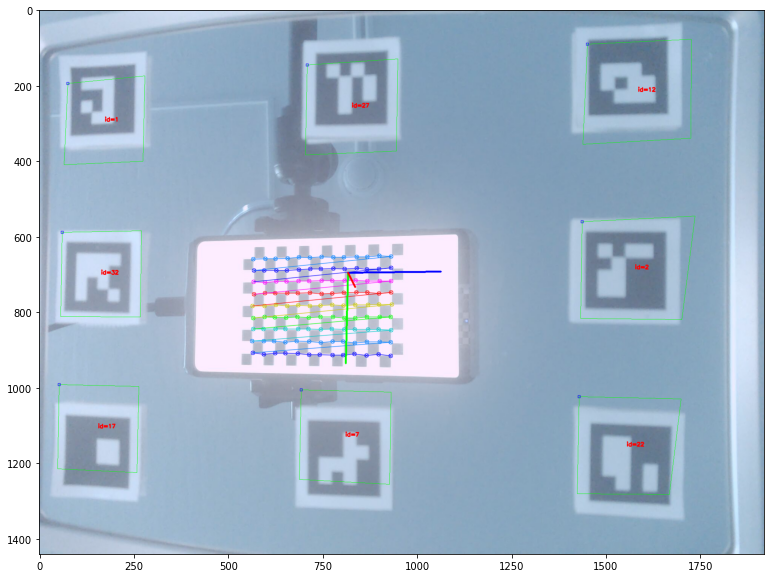

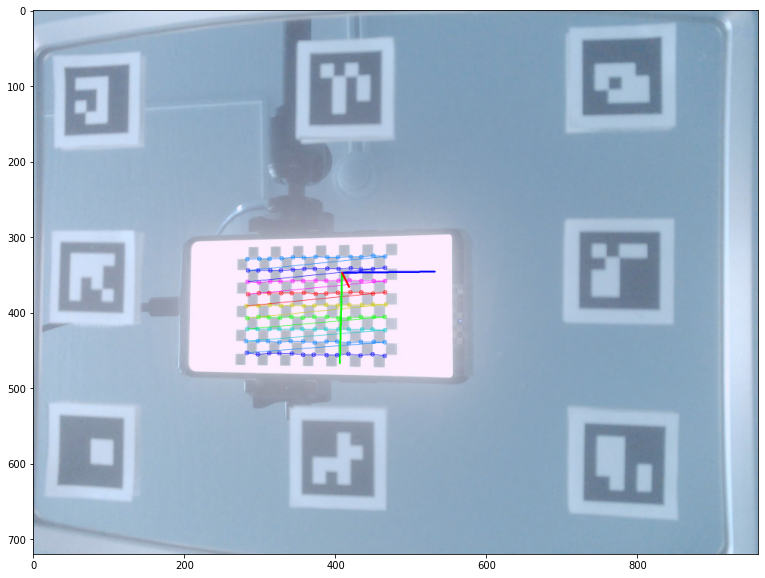

[[-0.00407766]
 [-0.03082978]
 [ 0.29522823]]
rC2S: [[ 0.99748325  0.02625126 -0.0658637 ]
 [ 0.02937585 -0.99846619  0.04692901]
 [ 0.06453074  0.0487457   0.99672446]]
tC2S: [ 0.05719681 -0.02816548  0.05733809]


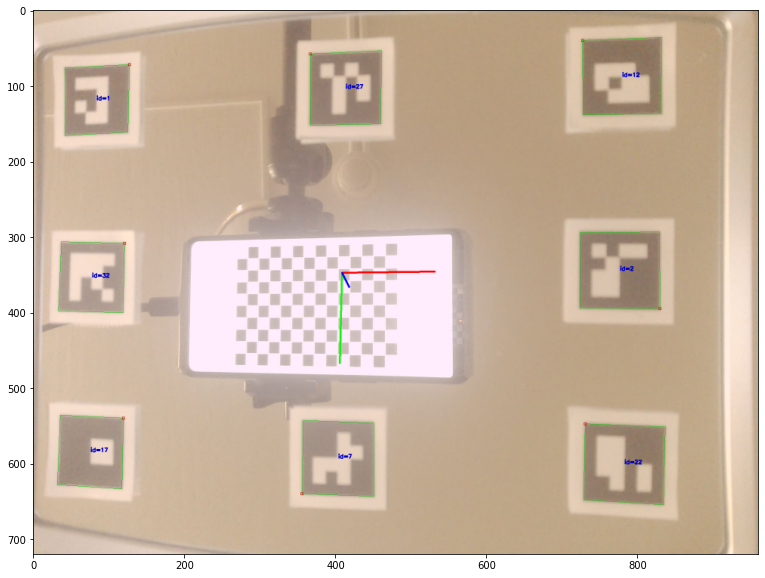

cam z axis in world coor:  [-0.15882753 -0.00138466  0.98730537]
cam zero point in world coor:  [ 0.01111787  0.02077825 -0.11481627]
display z axis in world coor:  [-0.09366401  0.04607592  0.99453711]
display zero in world coor:  [-0.04039461 -0.01037334 -0.17587747]


/var/folders/lh/7mmgwqb10p72cf_1ysf96ldh0000gn/T/ipykernel_9727/650108423.py:526: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


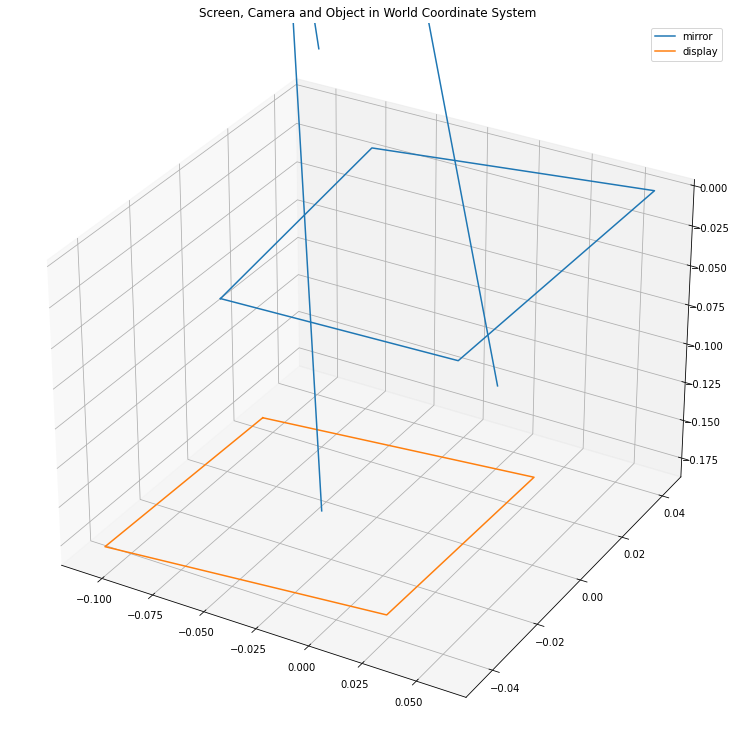

rawImg is  (1440, 1920, 3)
dispImg:  (943, 1920, 3)


<Figure size 1080x720 with 0 Axes>

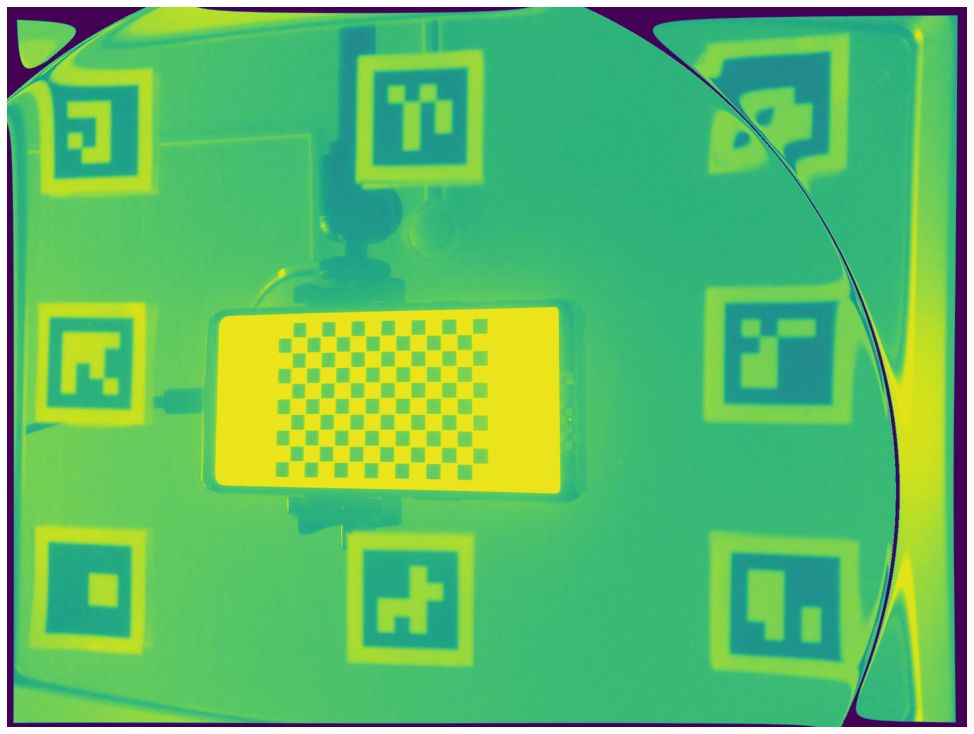

retrieveImage is  (3, 1920)


ValueError: operands could not be broadcast together with shapes (3,1920) (1440,1920) 

In [13]:
import sys, glob, os
import math
import argparse
import numpy as np
import cv2
from cv2 import aruco
from checkerboard import detect_checkerboard
# from Camera2ScreenCalib import calib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

JPGPattern = "*.jpg"

# TODO: Display dimensions
SCREEN_WIDTH = 1920 #2200->1920
SCREEN_HEIGHT = 940 #1080->960

# Aruco marker on the mirror dimensions (m)

# aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_250)
aruco_dict = aruco.getPredefinedDictionary(aruco.DICT_4X4_250) # API changed for 4.7.x

def readFileList(imgFolder, ImgPattern=JPGPattern):
    imgFileList = glob.glob(os.path.join(imgFolder, ImgPattern))
    imgFileList.sort()
    return imgFileList

def detectChecker(img, patternSize, debug=True):
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # gray = cv2.flip(gray, 1)
    elif len(img.shape) == 2:
        gray = img
        # gray = cv2.flip(gray, 1)

    ret, corners = cv2.findChessboardCorners(gray, patternSize, cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_EXHAUSTIVE)
    corners_refine = corners
    #print(ret)
 
    if ret:
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
        corners_refine = cv2.cornerSubPix(gray, corners, (3, 3), (-1, -1), criteria)

        if debug:
            cv2.drawChessboardCorners(img, patternSize, corners_refine, ret)
            width = 960
            height = int(img.shape[0] * 960 / img.shape[1])
            smallimg = cv2.resize(img, (width, height))
            # fig = plt.figure(figsize=(15,10))
            # plt.figure()
            # fig.imshow(smallimg)
            # print("image of checkerboard!!!!!!!!!!!!!!!!!!")
            # plt.show()
            # fig.show()

    return ret, corners_refine

def readCheckerObjPoint(fname):
    data = np.load(fname)
    objp = data["objp"]
    return objp

def arucoBoard(m, h= 0.1465, w= 0.107):
    # create objPoints for calibration target
    h0 = (0 - h / 2)
    hm = (m - h / 2)
    h1 = (((h - m) / 2) - h / 2)
    h2 = (((h + m) / 2) - h / 2)
    h3 = ((h - m) - h / 2)
    h4 = (h - h / 2)
    w0 = (0 - w / 2)
    wm = (m - w / 2)
    w1 = (((w - m) / 2) - w / 2)
    w2 = (((w + m) / 2) - w / 2)
    w3 = ((w - m) - w / 2)
    w4 = (w - w / 2)

    objPoints = []
    objPoints.append(np.array([[w0, h0, 0], [wm, h0, 0], [wm, hm, 0], [w0, hm, 0]], dtype=np.float32))  # 0
    objPoints.append(np.array([[w0, h1, 0], [wm, h1, 0], [wm, h2, 0], [w0, h2, 0]], dtype=np.float32))  # 1
    objPoints.append(np.array([[w0, h3, 0], [wm, h3, 0], [wm, h4, 0], [w0, h4, 0]], dtype=np.float32))  # 2
    objPoints.append(np.array([[w1, h3, 0], [w2, h3, 0], [w2, h4, 0], [w1, h4, 0]], dtype=np.float32))  # 3
    objPoints.append(np.array([[w3, h3, 0], [w4, h3, 0], [w4, h4, 0], [w3, h4, 0]], dtype=np.float32))  # 4
    objPoints.append(np.array([[w3, h1, 0], [w4, h1, 0], [w4, h2, 0], [w3, h2, 0]], dtype=np.float32))  # 5
    objPoints.append(np.array([[w3, h0, 0], [w4, h0, 0], [w4, hm, 0], [w3, hm, 0]], dtype=np.float32))  # 6
    objPoints.append(np.array([[w1, h0, 0], [w2, h0, 0], [w2, hm, 0], [w1, hm, 0]], dtype=np.float32))  # 7

    # ids = np.linspace(0, 7, 8).astype(np.int32)[:, None]
    ids = np.array([1, 32, 17, 7, 22, 2, 12, 27])
    # ids = np.array([[22], [7], [17], [32], [2], [1], [27], [12]])

    
    arucoCornerBoard = aruco.Board_create(objPoints, aruco_dict, ids)

    return arucoCornerBoard, objPoints

def detectAruco(img, debug=True):
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    elif len(img.shape) == 2:
        gray = img

    parameters = aruco.DetectorParameters_create()
    #corners, ids, rejectedImgPoints = aruco.detectMarkers(img, aruco_dict, parameters=parameters)
    corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict, parameters=parameters)

    if debug:
        frame_markers = aruco.drawDetectedMarkers(img.copy(), corners, ids)
        width = 960
        height = int(img.shape[0] * 960 / img.shape[1])
        smallimg = cv2.resize(frame_markers, (width, height))
        plt.figure(figsize=(15,10))
        plt.imshow(smallimg)
        plt.show()
        print("image of Aruco!!!!!!!!!!!!!!!!!!")

    return corners, ids

def postEst(corners, ids, camMat, distCoeffs, markerLength, arucoBoardHeight= 0.083, arucoBoardWidth= 0.125):
    arucoCornerBoard, _ = arucoBoard(markerLength, arucoBoardHeight, arucoBoardWidth)

    rvec = []
    tvec = []
    retval, rvec, tvec = aruco.estimatePoseBoard(corners, ids, arucoCornerBoard, camMat, distCoeffs, None, None)

    return rvec, tvec

def reProjAruco(img, camMat, distCoeffs, rvec, tvec, cornersAruco, markerLength, arucoBoardHeight= 0.085, arucoBoardWidth= 0.127):
    _, objPoints = arucoBoard(markerLength, arucoBoardHeight, arucoBoardWidth)

    # ids = np.linspace(0, 7, 8).astype(np.int32)[:, None]
    # ids = np.array([[22], [7], [17], [32], [2], [1], [27], [12]])
    ids = np.array([1, 32, 17, 7, 22, 2, 12, 27])
    corners_reproj = []
    for i in range(len(objPoints)):
        imgPoints, _ = cv2.projectPoints(np.array(objPoints[i]), rvec, tvec, camMat, distCoeffs)
        corners_reproj.append(imgPoints)

    frame_markers = aruco.drawDetectedMarkers(img.copy(), corners_reproj, ids)
    fig = plt.figure(figsize=(15,10))
    plt.imshow(frame_markers)
    imgPath = './data/geometric_result'
    fig.savefig(imgPath + '/reproject_markers' + '.png')
    plt.show()

def householderTransform(n, d):
    I3 = np.identity(3, dtype=np.float32)
    e = np.array([0, 0, 1])
    p1 = I3 - 2 * np.outer(n, n)
    p2 = I3 - 2 * np.outer(e, e)
    p3 = 2 * d * n

    return p1, p2, p3

def invTransformation(R, t):
    Rinv = R.T
    Tinv = -(Rinv@t)

    return Rinv, Tinv

def by_num_ele(start,step,n_elements):
    return np.arange(start,start+step*n_elements,step)

def generateObjP(checkerH, checkerV, squareSize):
    # 3D coordinates of the corners of the checkerboard pattern
    a = checkerH
    b = checkerV
    m = squareSize
    displayLength = 2200
    displayWidth = 1080

    Xpts = by_num_ele(-(a-2)*m/2 + displayLength/2, m, (a-1))
    Ypts = by_num_ele(-(b-2)*m/2 + displayWidth/2, m, (b-1))
    X2D,Y2D = np.meshgrid(Xpts,Ypts)
    objp2D = np.column_stack((X2D.ravel(),Y2D.ravel()))
    objp3D = np.insert(objp2D, 2, 0, axis=1)

    return objp3D

def calib(imgPath, camMtx, dist, half_length, half_height, displayScaleFactor, checker_col_row, marker_size):
    
    # imgFileList = readFileList(imgPath, JPGPattern) # Retrieve Images
    
    ARUCO_BOARD_HEIGHT = half_height * 2 
    ARUCO_BOARD_WIDTH = half_length * 2 
    CHECKSQUARE_SIZE = displayScaleFactor

    # objP_pixel = np.ceil(readCheckerObjPoint(CHECKER_FILE))
    
    # print("checker_col_row: col is ", checker_col_row[0] + 1)
    # print("checker_col_row: row is ",  checker_col_row[1] +  1)
    
    objP_pixel = np.ceil(generateObjP(checker_col_row[0] + 1, checker_col_row[1] +  1, 85)) # change 100 -> 85
    objP_pixel[:, 2] = 0
    objP = np.array(objP_pixel)
    for i in range(checker_col_row[1]):
        for j in range(math.floor(checker_col_row[0]/2)):
            tmp = objP[checker_col_row[0] * i + j, 0]
            objP[checker_col_row[0] * i + j, 0] = objP[checker_col_row[0] * i + checker_col_row[0] - j - 1, 0]
            objP[checker_col_row[0] * i + checker_col_row[0] - j - 1, 0] = tmp
    objP[:, 0] -= (SCREEN_WIDTH / 2 - 1)
    objP[:, 1] -= (SCREEN_HEIGHT / 2 - 1)

    objP *= CHECKSQUARE_SIZE
    

    rtA = []
    rB = []
    tB = []
    rC2Ss = []
    tC2Ss = []

    # define valid image
    validImg = -1
    for i in range(1):
        #img = cv2.imread(imgPath, cv2.IMREAD_UNCHANGED)
        img = cv2.imread(imgPath)

        # Detect aruco marker for mirror position
        cornersAruco, ids = detectAruco(img, debug=False)
        if cornersAruco is None and ids is None and len(cornersAruco) <= 3:
            continue # if aruco marker not detected or less than 3 detected, skip

        # Detect Checker for Monitor Display
        ret, cornersChecker = detectChecker(img, checker_col_row, debug=True)
                
        if not ret:
            print("no Checker!!!")
            continue
        
        #for a valid image, aruco and checker must be both detected
        validImg += 1

        # Calibrate Mirror Pose with Aruco
        rvecMirror, tvecMirror = postEst(cornersAruco, ids, camMtx, dist, marker_size, ARUCO_BOARD_HEIGHT, ARUCO_BOARD_WIDTH)
        img_axis = aruco.drawAxis(img, camMtx, dist, rvecMirror, tvecMirror, marker_size)
        width = 960
        height = int(img_axis.shape[0] * 960 / img_axis.shape[1])
        smallimg = cv2.resize(img_axis, (width, height))
        # plt.figure(figsize=(15,10))
        # plt.imshow(smallimg)
        # plt.show()

        ## Reproejct Camera Extrinsic
        reProjAruco(img, camMtx, dist, rvecMirror, tvecMirror, cornersAruco, marker_size, ARUCO_BOARD_HEIGHT, ARUCO_BOARD_WIDTH)
        rMatMirror, _ = cv2.Rodrigues(rvecMirror)  # rotation vector to rotation matrix
        normalMirror = rMatMirror[:, 2]

        rC2W, tC2W = invTransformation(rMatMirror, tvecMirror)
        dW2C = abs(np.dot(normalMirror, tvecMirror))

        # Householder transformation
        p1, p2, p3 = householderTransform(normalMirror, dW2C)

        # Calibrate virtual to Camera with Checker
        rpe, rvecVirtual, tvecVirtual = cv2.solvePnP(objP, cornersChecker, camMtx, dist, flags=cv2.SOLVEPNP_IPPE)  # cv2.SOLVEPNP_IPPE for 4 point solution #cv2.SOLVEPNP_ITERATIVE
                                                                      #iterationsCount=200, reprojectionError=8.0,

        rvecVirtual, tvecVirtual = cv2.solvePnPRefineLM(objP, cornersChecker, camMtx, dist, rvecVirtual, tvecVirtual)

        proj, jac = cv2.projectPoints(objP, rvecVirtual, tvecVirtual, camMtx, dist)
        img_rep = img

        # cv2.drawChessboardCorners(img_rep, CHECKERPATTERN_SIZE, proj, True)
        width = 960
        height = int(img_rep.shape[0] * 960 / img_rep.shape[1])
        smallimg = cv2.resize(img_rep, (width, height))
        fig = plt.figure(figsize=(15,10))
        plt.imshow(smallimg)
        imgPath = './data/geometric_result'
        fig.savefig(imgPath + '/chesssBoard' + '.png')
        plt.show()

        rMatVirtual, _ = cv2.Rodrigues(rvecVirtual)  # rotation vector to rotation matrix

        print(tvecVirtual)
        if validImg == 0:
            rtA = p1
            rB = np.matmul(rMatVirtual, p2)
            tB = np.squeeze(tvecVirtual) + p3
        else:
            rtA = np.concatenate((rtA, p1))
            rB = np.concatenate((rB, np.matmul(rMatVirtual, p2)))
            tB = np.concatenate((tB, np.squeeze(tvecVirtual) + p3))

        rS2C = p1 @ rMatVirtual
        tS2C = p1 @ np.squeeze(tvecVirtual) + p3

        rC2S, tC2S = invTransformation(rS2C, tS2C)
        print("rC2S:", rC2S)
        print("tC2S:", tC2S)
        rC2Ss.append(rC2S)
        tC2Ss.append(tC2S)

    return rC2Ss, tC2Ss

def geoCalib(imgFile, imgUndistortFile, half_length, half_height, marker_size, cameraMatrix, disCoeffs, displayScaleFactor, checker_col_row):
    # calculate cam2screen
    rc2s, tc2s = calib(imgFile, cameraMatrix, disCoeffs, half_length, half_height, displayScaleFactor, checker_col_row, marker_size)
    tc2s = tc2s[0]
    #print("new rc2s is ", rc2s)
    #print("new tc2s is ", tc2s)
    rcamera_dis = rc2s
    tcamera_dis = tc2s
    # additional section: Make sure that the shape of rC2S and tC2S is correct
    rcamera_dis = rcamera_dis[0]
    tcamera_dis = np.reshape(tcamera_dis, (3,))
    #print("rc2s is ",rcamera_dis)
    #print("tc2s is ",tcamera_dis)
    #print("intrinsic matrix is ",cameraMatrix)


    #print(intrinsic_mat.f.dist)
    allCorners = []
    allIds = []
    decimator = 0
    # dictionary = aruco.getPredefinedDictionary(cv2.aruco.DICT_6X6_250)
    dictionary = aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_250)
    
    img = cv2.imread(imgFile)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    cornerRefine = cv2.aruco.CORNER_REFINE_CONTOUR
    [markerCorners,markerIDs, rejectedImgPoints] = cv2.aruco.detectMarkers(gray, dictionary, cameraMatrix=cameraMatrix, distCoeff=disCoeffs)
    
    board_corner = np.array([np.array([[-half_length, -half_height, 0], [-half_length + marker_size, -half_height, 0], [-half_length + marker_size, -half_height + marker_size, 0], [-half_length, -half_height + marker_size, 0]]),
                    np.array([[half_length - marker_size, -half_height, 0], [half_length, -half_height, 0], [half_length, -half_height + marker_size, 0], [half_length - marker_size, -half_height + marker_size, 0]]),
                    np.array([[half_length - marker_size, half_height - marker_size, 0], [half_length, half_height - marker_size, 0], [half_length, half_height, 0], [half_length - marker_size, half_height, 0]]),
                    np.array([[-half_length, half_height - marker_size, 0], [-half_length + marker_size, half_height - marker_size, 0], [-half_length + marker_size, half_height, 0], [-half_length, half_height, 0]]),
                    np.array([[-marker_size/2, -half_height, 0], [marker_size/2, -half_height, 0], [marker_size/2, -half_height + marker_size, 0], [-marker_size/2, -half_height + marker_size, 0]]),
                    np.array([[-half_length, -marker_size/2, 0], [-half_length + marker_size, -marker_size/2, 0], [-half_length + marker_size, marker_size/2, 0], [-half_length, marker_size/2, 0]]),
                    np.array([[half_length - marker_size, -marker_size/2, 0], [half_length, -marker_size/2, 0], [half_length, marker_size/2, 0], [half_length - marker_size, marker_size/2, 0]]),
                    np.array([[-marker_size/2, half_height - marker_size, 0], [marker_size/2, half_height - marker_size, 0], [marker_size/2, half_height, 0], [-marker_size/2, half_height, 0]])], dtype=np.float32)
    # board_id = np.array([[0], [6], [4], [2], [7], [1], [5], [3]], dtype=np.int32)
    board_id = np.array([[1], [12], [22], [17], [27], [32], [2], [7]], dtype=np.int32)
    board = cv2.aruco.Board_create(board_corner, dictionary, board_id)

    if len(markerCorners) > 0:
        allCorners.append(markerCorners)
        allIds.append(markerIDs)
        cv2.aruco.drawDetectedMarkers(img, markerCorners, markerIDs, [0,200,0])

    #cv2.aruco.drawPlanarBoard(board, img.shape)
    rvecs,tvecs,_objpoints = cv2.aruco.estimatePoseSingleMarkers(markerCorners, marker_size, cameraMatrix, disCoeffs, )
    r_mean = np.mean(rvecs,axis=0)
    t_mean = np.mean(tvecs,axis=0)

    #r_mirror = np.zeros((1,3))
    #t_mirror = np.zeros((1,3))
    r_mirror = None
    t_mirror = None
    ret, r_mirror, t_mirror, = cv2.aruco.estimatePoseBoard(markerCorners, markerIDs, board, cameraMatrix, disCoeffs, r_mirror, t_mirror)
    #print("r vec of mirror is ", r_mirror)
    #print("t vec of mirror is ", t_mirror)
    r_mirror_mat = np.zeros((3,3))
    r_mirror_mat = cv2.Rodrigues(r_mirror, dst= r_mirror_mat, jacobian=None)
    r_mirror_mat = r_mirror_mat[0]
    #print("r mirror mat is ", r_mirror_mat)
    img_axis = aruco.drawAxis(img, cameraMatrix, disCoeffs, r_mirror, t_mirror, marker_size)
    width = 960
    height = int(img.shape[0]*960/img.shape[1])
    smallimg = cv2.resize(img,(width,height))
    smallimg = cv2.cvtColor(smallimg, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize=(15,10))
    plt.imshow(smallimg)
    # print(str(decimator) + '!!!!!!!!!!!!')
    imgSavePath = './data/geometric_result'
    fig.savefig(imgSavePath + '/findAllAruco' + '.png')
    plt.show()
    decimator+=1


    #rtcam: camera coordinate system to world coordinate system
    #rtMat: world coordinate system to camera coordinate system
    rtMat = np.hstack((r_mirror_mat, t_mirror))
    rtMat = np.vstack((rtMat, np.array([[0, 0, 0, 1]])))
    rt_cam = np.linalg.inv(rtMat)
    r_cam = rt_cam[0:3, 0:3]
    t_cam = rt_cam[0:3, 3]
    #print("rtMat is", rtMat)
    #print("rtcam in world coor is ", rt_cam)

    #rtdis: display coordinate system to world coordinate system
    #rtdis_inv: world coordinate system to display coordinate system
    t_camdis = np.reshape(tcamera_dis, (tcamera_dis.shape[0],1))
    rtMat_camdis = np.hstack((rcamera_dis, t_camdis))
    rtMat_camdis = np.vstack((rtMat_camdis, np.array([0,0,0,1])))
    #rtMat_discam = np.linalg.inv(rtMat_camdis)
    #rt_dis_inv = np.matmul(rtMat, rtMat_camdis)
    rt_dis_inv = np.matmul(rtMat_camdis, rtMat)
    rt_dis = np.linalg.inv(rt_dis_inv)
    r_dis = rt_dis[0:3, 0:3]
    t_dis = rt_dis[0:3,3]
    r_dis_inv = rt_dis_inv[0:3,0:3]
    t_dis_inv = rt_dis_inv[0:3,3]

    #rtMat_camdis: camera coordinate to display coordinate system
    #rtMat_discam: display coordinate to camera coordinate system
    rtMat_discam = np.linalg.inv(rtMat_camdis)


    #print("rtscreen in world coor is ", rt_dis)
    #print("mirror in screen coor is ",rt_dis_inv)
    #print("display to camera coor is ", rtMat_discam)
    #reshape t vector
    t_cam = np.reshape(t_cam, (t_cam.shape[0], 1))
    t_dis = np.reshape(t_dis, (t_dis.shape[0], 1))
    t_dis_inv = np.reshape(t_dis_inv, (t_dis_inv.shape[0], 1))



    # read undistorted image
    img_undistort = cv2.imread(imgUndistortFile)
    gray_undistort = cv2.cvtColor(img_undistort, cv2.COLOR_BGR2GRAY)
    img_undistort_size = gray_undistort.shape
    #print(img_undistort_size)


    #cam roor mat:store arrival vectors (vector from camera to the object) in camera coordinate system
    #cam world coor mat: store arrival vectors in world coordinate system
    #camera mirror intersect mat: store intersect points between arrival vectors and mirror in world coordinate system
    # reflec mat: store reflectance vectors (vector from object to screen) in world coordinate system 
    # mirror intersect mat trans:store intersect points on mirrors at display coordinate system
    # reflect mat trans: store reflectance vectors in display coordinate system
    # display intersect mat: store display intersect points (intersect points between reflectance vectors and display) on display coordinate system
    # display intersect mat trans: store display intersect points on world coordinate system
    img_coor_mat = np.zeros((3, img_undistort_size[0], img_undistort_size[1]))
    img_coor_mat_rs = np.zeros((3, img_undistort_size[0] * img_undistort_size[1]))
    cam_coor_mat = np.zeros((img_undistort_size[0], img_undistort_size[1], 3))
    cam_coor_mat_rs = np.zeros((3, img_undistort_size[0] * img_undistort_size[1]))
    cam_world_coor_mat = np.zeros((3, img_undistort_size[0] * img_undistort_size[1]))
    cam_mirror_intersect_mat = np.zeros((3, img_undistort_size[0] * img_undistort_size[1]))
    reflect_mat = np.zeros((3, img_undistort_size[0] * img_undistort_size[1]))
    mirror_intersect_mat_trans = np.zeros((3, img_undistort_size[0] * img_undistort_size[1]))
    reflect_mat_trans = np.zeros((3, img_undistort_size[0] * img_undistort_size[1]))
    display_intersect_mat = np.zeros((3, img_undistort_size[0] * img_undistort_size[1]))
    display_intersect_mat_trans = np.zeros((3, img_undistort_size[0] * img_undistort_size[1]))

    #print(cam_coor_mat.shape)
    #print(np.linalg.inv(cameraMatrix))
    for i in range(img_undistort_size[0]):
        for j in range(img_undistort_size[1]):
            image_coor = np.array([j + 1, i + 1, 1])
            img_coor_mat[:, i, j] = image_coor

    img_coor_mat_rs = np.reshape(img_coor_mat, (3, img_undistort_size[0] * img_undistort_size[1]))
    #print(img_coor_mat_rs[:,1201])
    # calculate arrival vector
    cam_coor_mat_rs = np.matmul(np.linalg.inv(cameraMatrix), img_coor_mat_rs)
    cam_world_coor_mat = np.matmul(r_cam, cam_coor_mat_rs)
    # calculate intersect point
    scale_factor1 = -t_cam[2,0] / cam_world_coor_mat[2,:]
    scale_factor1 = np.reshape(scale_factor1, (1, scale_factor1.shape[0]))
    cam_mirror_intersect_mat = scale_factor1 * cam_world_coor_mat + np.tile(t_cam, (cam_world_coor_mat.shape[1]))
    # calculate reflectance vector in world coor system
    reflect_mat = cam_world_coor_mat - 2 * np.dot(np.array([0,0,1]), cam_world_coor_mat) * np.tile(np.array([[0],[0],[1]]), (1, cam_world_coor_mat.shape[1]))
    # calculate intersect point in display coor system
    mirror_intersect_mat_trans = np.dot(r_dis_inv, cam_mirror_intersect_mat) + np.tile(t_dis_inv, (cam_world_coor_mat.shape[1]))
    # calculate reflectance vector in display coor system
    reflect_mat_trans = np.dot(r_dis_inv, reflect_mat)
    # calculate display intersect point under display coordinate system
    scale_factor2 = -mirror_intersect_mat_trans[2,:] / reflect_mat_trans[2,:]
    display_intersect_mat = scale_factor2 * reflect_mat_trans + mirror_intersect_mat_trans
    # calculate display intersect point under world coordinate system
    display_intersect_mat_trans = np.dot(r_dis, display_intersect_mat) + np.tile(t_dis, (cam_world_coor_mat.shape[1]))

    # restore the matrix back to the same shape of undistort image
    display_intersect_mat = np.reshape(display_intersect_mat, (img_undistort_size[0], 3, img_undistort_size[1]))
    display_intersect_mat_trans = np.reshape(display_intersect_mat_trans, (3, img_undistort_size[0], img_undistort_size[1]))
    cam_mirror_intersect_mat = np.reshape(cam_mirror_intersect_mat, (3, img_undistort_size[0], img_undistort_size[1]))

    #np.savetxt("displayintersect0.txt",display_intersect_mat[0,:,:])
    #np.savetxt("displayintersect1.txt",display_intersect_mat[1,:,:])

    ## this part is to display camera, mirror &projector within a unified world coordinate systems

    #reshape t vector
    t_cam = np.reshape(t_cam, (t_cam.shape[0],))
    t_dis = np.reshape(t_dis, (t_dis.shape[0],))
    t_dis_inv = np.reshape(t_dis_inv, (t_dis_inv.shape[0], ))

    #mirror corner index
    markerCornerIDs = np.array([np.argwhere(markerIDs == 1), np.argwhere(markerIDs == 17), np.argwhere(markerIDs == 22), np.argwhere(markerIDs == 12)])
    markerCornerIDs = markerCornerIDs[:,0,0]

    mirror_corner_value = np.array([markerCorners[markerCornerIDs[0]][0][0],
    markerCorners[markerCornerIDs[1]][0][3],
    markerCorners[markerCornerIDs[2]][0][2],
    markerCorners[markerCornerIDs[3]][0][1],
    markerCorners[markerCornerIDs[0]][0][0]], dtype=np.int32)
    #print("mirror corner index is", mirror_corner_value)
    mirror_corner_world = np.zeros((mirror_corner_value.shape[0],3))
    for i in range(mirror_corner_world.shape[0]):
        mirror_corner_world[i,:] = cam_mirror_intersect_mat[:, mirror_corner_value[i,1], mirror_corner_value[i,0]]
    #print("mirror corner point is", mirror_corner_world)

    #display corners in world coordinate system
    half_length_disp = 960 * displayScaleFactor
    half_height_disp = 470 * displayScaleFactor
    disp_uleft = np.array([-half_length_disp, -half_height_disp, 0])
    disp_lleft = np.array([-half_length_disp, half_height_disp, 0])
    disp_lright = np.array([half_length_disp, half_height_disp, 0])
    disp_uright = np.array([half_length_disp, -half_height_disp, 0])
    disp_uleft_world = np.reshape(np.matmul(r_dis, disp_uleft) + t_dis, (1, t_dis.shape[0]))
    disp_lleft_world = np.reshape(np.matmul(r_dis, disp_lleft) + t_dis, (1, t_dis.shape[0]))
    disp_lright_world = np.reshape(np.matmul(r_dis, disp_lright) + t_dis, (1,t_dis.shape[0]))
    disp_uright_world = np.reshape(np.matmul(r_dis, disp_uright) + t_dis, (1, t_dis.shape[0]))

    disp_corners_world = np.concatenate((disp_uleft_world, disp_lleft_world, disp_lright_world, disp_uright_world, disp_uleft_world), axis= 0)
    #print("disp corners in world coordinate is ", disp_corners_world)

    # calculate the (0,0) and z axis of camera and display (for verification)
    cam_z1 = np.matmul(r_cam, np.array([0,0,1])) + t_cam
    cam_zero = np.matmul(r_cam, np.array([0,0,0])) + t_cam
    display_z1 = np.matmul(r_dis,np.array([0,0,1])) + t_dis
    display_zero = np.matmul(r_dis,np.array([0,0,0])) + t_dis
    #cam_z = np.concatenate((np.reshape(cam_zero, (1, cam_zero.shape[0])), np.reshape(cam_z1, (1, cam_z1.shape[0]))), axis= 0)
    #display_z = np.concatenate((np.reshape(display_zero, (1,display_zero.shape[0])), np.reshape(display_z1, (1, display_z1.shape[0]))), axis= 0)
    cam_z = cam_z1 - cam_zero
    display_z = display_z1 - display_zero
    print('cam z axis in world coor: ',cam_z)
    print("cam zero point in world coor: ", cam_zero)
    print("display z axis in world coor: ", display_z)
    print("display zero in world coor: ", display_zero)
    # plot 
    fig = plt.figure(figsize=(15,10))
    ax = Axes3D(fig)
    ax.plot(mirror_corner_world[:,0], mirror_corner_world[:,1], mirror_corner_world[:,2], label= 'mirror')
    ax.plot(disp_corners_world[:,0], disp_corners_world[:,1], disp_corners_world[:,2], label= 'display')
    ax.quiver(cam_zero[0], cam_zero[1], cam_zero[2], cam_z[0], cam_z[1], cam_z[2], length= 0.4)
    ax.quiver(display_zero[0], display_zero[1], display_zero[2], display_z[0], display_z[1], display_z[2], length= 0.4)
    plt.title("Screen, Camera and Object in World Coordinate System")
    plt.legend()
    plt.show()
    imgPath = './data/geometric_result/'
    fig.savefig(imgPath + '/Screen, Camera and Object in World Coordinate System' + '.png')
    
    return display_intersect_mat, cam_mirror_intersect_mat, rcamera_dis, tcamera_dis

def geo_calib_validation(geoCalibImgUndistortFile, displayintersect, displayScaleFactor, checker_col_row):
    displayintersectX = displayintersect[0,:,:]
    displayintersectY = displayintersect[1,:,:]
    displayintersectX = -displayintersectX
    displayintersectX = displayintersectX / displayScaleFactor
    displayintersectY = displayintersectY / displayScaleFactor

    rawImg = cv2.imread(geoCalibImgUndistortFile)
    print("rawImg is ", rawImg.shape)
    rawImgGray = cv2.cvtColor(rawImg, cv2.COLOR_BGR2GRAY)
    ret, corners_raw = cv2.findChessboardCorners(rawImgGray, checker_col_row, cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_EXHAUSTIVE)

    dispImg = cv2.imread("./data/geometric_chessboard.png")
    print("dispImg: ", dispImg.shape)
    # dispImg = cv2.imread("./data/capture_geometric/geoCali.jpg")    
    # dispImg = cv2.imread("./10_14_checker.png") # Yunhao original board
    dispImgGray = cv2.cvtColor(dispImg, cv2.COLOR_BGR2GRAY)
    dispImgGray = cv2.flip(dispImgGray, 1)

    fig = plt.figure(figsize=(15,10))
    fig = plt.figure(frameon=False)
    fig.set_size_inches(15,10)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    plt.imshow(rawImgGray)
    imgSavePath = './data/geometric_result'
    fig.savefig(imgSavePath + '/original' + '.png')
    plt.show()

    minX = -dispImgGray.shape[1] / 2
    maxX = dispImgGray.shape[1] / 2
    minY = -dispImgGray.shape[0] / 2
    maxY = dispImgGray.shape[0] / 2
    dispPattern = dispImgGray

    retrieveImage = np.zeros((displayintersectX.shape[0], displayintersectX.shape[1]))
    print("retrieveImage is ", retrieveImage.shape)
    for i in range(retrieveImage.shape[0]):
        for j in range(retrieveImage.shape[1]):
            roundCor = [np.round(displayintersectY[i,j]), np.round(displayintersectX[i,j])]
            if minY < roundCor[0] and roundCor[0] < maxY and minX < roundCor[1] and roundCor[1] < maxX:
                #print(int(roundCor[0] + maxY), int(roundCor[1] + maxX))
                retrieveImage[i,j] = dispPattern[int(roundCor[0] + maxY), int(roundCor[1] + maxX)]
    
    compareImg = retrieveImage * 0.5 + rawImgGray + 0.5
    
    fig = plt.figure(figsize=(15,10))
    plt.imshow(retrieveImage)
    fig.savefig(imgSavePath + '/reprojected' + '.png')
    plt.show()

    retrieveImageGray = cv2.cvtColor((retrieveImage).astype(np.uint8), cv2.COLOR_GRAY2BGR)
    ret, corners_reproj = cv2.findChessboardCorners(retrieveImageGray, checker_col_row, cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_EXHAUSTIVE)
    distances = np.sqrt(np.sum((corners_raw - corners_reproj)**2, axis=2))
    rms = np.sqrt(np.mean(distances**2))
    print("Rep Error:", rms)

    fig = plt.figure(figsize=(15,10))
    fig = plt.figure(frameon=False)
    fig.set_size_inches(15,10)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    plt.imshow(compareImg)
    fig.savefig(imgSavePath + '/comparison' + '.png')
    plt.show()

if __name__ == '__main__':
    
    imgFile = "./data/capture_geometric/geoCali.jpg"
    imgUndistortFile = "./data/capture_geometric/undistort/geoCali.jpg"
    
    half_length = 0.0615 # 6.75cm
    half_height = 0.0415 # 4.65cm
    marker_size = 0.018  # 18mm
    displayScaleFactor = 0.006 / 85
    
    cameraMatrix = np.array([[1.5163419e+03, 0.00000000e+00, 7.15673857e+02],
                             [0.00000000e+00, 1.51901413e+03, 9.68117419e+02],
                             [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])
    disCoeffs = np.array([[1.17319849e+01, 1.37450951e+01, -2.27996809e-04, -1.18358080e-03,
                           -9.22997809e+01, 1.13161285e+01, 1.41907175e+01, -9.11921287e+01,
                           0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
                           0.00000000e+00, 0.00000000e+00]])
    checker_col_row = np.array([13,9])
    
    display_intersect_mat, cam_mirror_intersect_mat, rcamera_dis, tcamera_dis = geoCalib(imgFile, imgUndistortFile, half_length, half_height, marker_size, cameraMatrix, disCoeffs, displayScaleFactor, checker_col_row)
    
    geo_calib_validation(imgUndistortFile, display_intersect_mat, displayScaleFactor, checker_col_row)